In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Загрузка данных, добавление столбца приращения

В качестве данных был выбран курс доллара к евро с интервалом 4 часа.
Open -- курс (сколько долларов стоит 1 евро) на момент начала рассматриваемого часа. Будем работать с этими значениями.
delta -- разница в цене рассматриваемого часа с предыдущим. Из выборки было взято 10000 значений, идущих подряд.

In [139]:
currency_data: pd.DataFrame = pd.read_csv("EURUSD_H4.csv", sep="\t", usecols=["Time", "Open"])
currency_data["delta"] = currency_data["Open"].shift(1) - currency_data["Open"]
currency_data = currency_data.fillna(value=0)

# Перемешаем delta
currency_data = currency_data.iloc[np.random.permutation(len(currency_data))]

data: np.ndarray = currency_data["delta"].iloc[:2500]

# Гистограмма для delta

Гистограмма для распределения delta. Столбец -- число записей, попавших в интервал, число интервалов -- 100. 
Строится автоматически, здесь не было задания строить гистограмму вручную

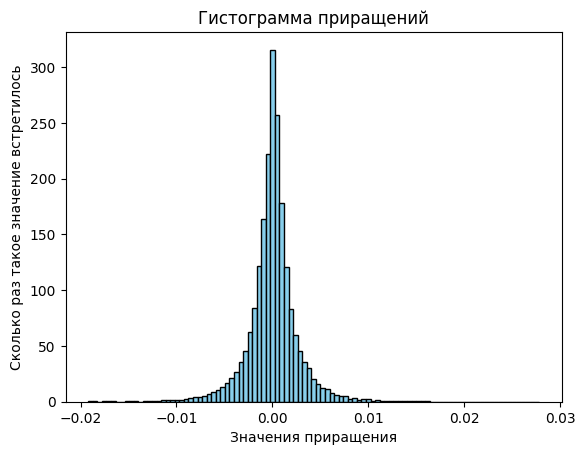

In [140]:
segments_count: int = 100
delta_min: float = np.min(data)
delta_max: float = np.max(data)

intervals: np.ndarray = np.linspace(delta_min, delta_max, segments_count)

plt.hist(currency_data["delta"], bins=intervals, color='skyblue', edgecolor='black', density=True)
# density -- нормировка, чтобы сумма площадей столбцов была равна 1
 
# Adding labels and title
plt.xlabel('Значения приращения')
plt.ylabel('Сколько раз такое значение встретилось')
plt.title('Гистограмма приращений')
 
# Display the plot
plt.show()

Визуально больше всего похоже на распределение Лапласа. Но проверим позднее

# Ядерная оценка плотности

Формула:
$f_n(x) = \frac{1}{nh_n} \sum_{i=1}^{i=n}g(\frac{x-x_i}{h_n})$

$n -число \ интервалов$

$f_n(x) -оценка \ плотности$

$h_n -интервал, \ все \ интервалы \ берутся \ одинаковые \ и \ можно \ использовать \ просто \ h$

$g - плотность \ известной \ функции, g(x) = G^'(x), G(x) - ядро$

В курсе упоминалось, что в качестве G часто берут стандартную нормальную функцию распределения. Начнем с нее же.

Тогда 

$g(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}$

Теперь посчитаем. Интервалы берем одинаковые, за левую и правую грани -- минимальные и максимальные значения delta, размер интервала задаем числом n.

Вычисляем минимум, максимум и размер интервала по заданному n

In [141]:
segments_count: int = 100
delta_min: float = np.min(data)
delta_max: float = np.max(data)

intervals: np.ndarray = np.linspace(delta_min, delta_max, segments_count)
segment_size: float = (delta_max - delta_min) / segments_count

Функция вычисления плотности стандартного нормального распределения

In [142]:
def std_norm_density(x: float) -> float:
    """Функция плотности стандартного нормального распределения"""
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x ** 2))

Вычисление плотности по формуле выше

In [143]:
kde_values: np.ndarray = np.zeros_like(intervals)
for x in data:
    kde_values += std_norm_density((intervals - x) / segment_size)

kde_values /= (segment_size * len(data))


График полученной плотности и график delta

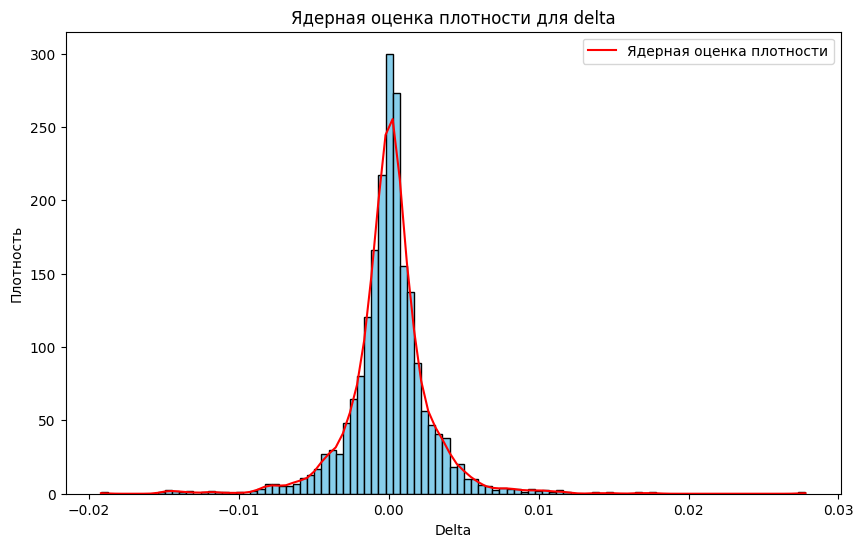

In [144]:
# Построение графика
segments_count: int = 100
delta_min: float = np.min(data)
delta_max: float = np.max(data)

intervals: np.ndarray = np.linspace(delta_min, delta_max, segments_count)

plt.figure(figsize=(10, 6))
plt.plot(intervals, kde_values, color="red", label='Ядерная оценка плотности')
plt.hist(data, bins=intervals, color='skyblue', edgecolor='black', density=True)
plt.xlabel('Delta')
plt.ylabel('Плотность')
plt.title('Ядерная оценка плотности для delta')
plt.legend()
plt.show()

Чем меньше интервалов, тем плавнее график. Чем их больше, тем больше он похож на гистограмму со слишком большим числом сегментов (что логично, в общем-то)

# Проверка принадлежности стандартному распределению, метод максимального правдоподобия

Первая гипотеза -- выборка изменений цен евро в долларах имеет нормальное распределение.
Для начала нужно оценить параметры выборки методом максимального правдоподобия.

Для начала вычислим математическое ожидание (a) и дисперсию ($\sigma^2$) методом максимального правдоподобия.

Если $\( X_1, X_2, \ldots, X_n \)$ — независимые одинаково распределенные случайные величины с нормальным распределением $\( N(a, \sigma^2) \)$, то функция правдоподобия для этих данных определяется как произведение плотностей вероятности для каждого наблюдения:

$\[L(a, \sigma^2 \mid X_1, X_2, \ldots, X_n) = \prod_{i=1}^n f(X_i \mid a, \sigma^2)\]$

где $\( f(X_i \mid a, \sigma^2) \)$ — плотность нормального распределения:

$\[f(X_i \mid a, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(X_i - a)^2}{2\sigma^2} \right)\]$

Таким образом, функция правдоподобия имеет вид:

$\[L(a, \sigma^2) = \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right)^n \exp\left( -\sum_{i=1}^n \frac{(X_i - a)^2}{2\sigma^2} \right)\]$

Логарифм функции правдоподобия (логарифмическая функция правдоподобия) удобнее максимизировать:

$\[\ln L(a, \sigma^2) = -\frac{n}{2} \ln (2\pi) - \frac{n}{2} \ln (\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (X_i - a)^2\]$


Для максимизации логарифмической функции правдоподобия нужно взять производные по \(a\) и \(\sigma^2\) и приравнять их к нулю.

**Для a**:
$\[\frac{\partial \ln L}{\partial a} = \frac{1}{\sigma^2} \sum_{i=1}^n (X_i - a) = 0\]$

Решая это уравнение, получаем оценку для \(a\):

$\[\hat{a} = \frac{1}{n} \sum_{i=1}^n X_i\]$

**Для $\(\sigma^2\)$**:

$\[\frac{\partial \ln L}{\partial \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4} \sum_{i=1}^n (X_i - a)^2 = 0\]$

Решая это уравнение, получаем оценку для $\(\sigma^2\)$:

$\[\hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^n (X_i - \hat{a})^2\]$

То есть получили стандартные формулы для математического ожидания и дисперсии выборки. Считать их будем через стандартные методы библиотеки. Метод моментов для нормального распределения даст те же формулы.


## Вычисление матожидания и дисперсии

In [145]:
# Рассчитываем математическое ожидание (среднее) и дисперсию
mean: float = np.mean(data)
variance: float = np.var(data)

print("a=", mean, "sigma^2=", variance)

a= 3.219200000000044e-05 sigma^2= 7.710905915135998e-06


## Проверка гипотезы критерием хи-квадрат
$$\[\nu_i = \sum_{i=1}^n I(X_j \in \delta_i)\]$$
$$p_i = P(X_j \in \delta_i), X_j - НОРСВ$$
$$\[\chi^2 = \sum_{i=1}^k \frac{(\nu_i - np_i)^2}{np_i}\]$$
   

Критерий Пирсона доказан только для интервалов, не зависящих от выборки. Так что возьмем разбиение на N сегментов на интервале, "на глаз" покрывающем выборку. $P_i$ -- вероятность попасть в i-й интервал. 

In [146]:
from utils import chi_square

# Задаем настройки разбиения
left: float = -1
right: float = 1
segment_count: int = 20

# Считаем величину
print(chi_square)
res: float = chi_square(data, left, right, segment_count)
print(res)

461.81776357226477


TypeError: 'numpy.float64' object is not callable